#### <h1><center>Reinforcement Learning</center></h1>

<center>
<h2>Deep Q-Networks</h2>
<center>


## Implementing DQN & Solving Various Problems

In [1]:
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import gym as gym
from gym import spaces
from matplotlib.offsetbox import OffsetImage,AnnotationBbox
from collections import namedtuple,deque

In [2]:
is_ipython='inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Implementing DQN & Solving grid-world environment

## DQN

In [3]:
transiton=namedtuple('transiton',('stt','actn','nxt_stt','rd'))
class replay_mem(object):
    def __init__(self,capicity):
        self.capicity=capicity
        self.total_rewards_rxrover=[]
        self.pos=0
    def push(self,*args):
        if len(self.mem)< self.capicity:
            self.mem.append(None)
        self.mem[self.pos]=transiton(*args)
        self.pos=(self.pos+1)% self.capicity
    def sample(self,batchsize):
        return random.sample(self.mem,batchsize)
    def __len__(self):
        return len(self.mem)

In [4]:
class DQN(nn.Module):
    def __init__(self,n_obs,n_act):
        super(DQN,self).__init__()
        self.l1=nn.Linear(n_obs,256)
        self.l2=nn.Linear(256,128)
        self.l3=nn.Linear(128,n_act)
    def forward(self,x):
        x=F.relu(self.l1(x))
        x=F.relu(self.l2(x))
        return self.l3(x)

In [5]:
def duration(show_result=False):
    plt.figure(1)
    t_dur=torch.tensor(epi_dur,
                       dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(t_dur.numpy())

    if len(t_dur)>= 100:
        means=t_dur.unfold(0,100,1).mean(1).view(-1)
        means=torch.cat((torch.zeros(99),
                         means))
        plt.plot(means.numpy())

    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [6]:
def select_action(sttenv):
    global stp_done
    sample=random.random()
    thres=eps_ends+(eps_begins-eps_ends)*math.exp(-1.*stp_done/decayy)
    stp_done += 1
    if sample>thres:
        with torch.no_grad():
            return policyy_network(stt).max(1).indices.view(1,1)
    else:
        return torch.tensor([[env.action_space.sample()]],
                            device=device,
                            dtype=torch.long)
    
def opt_m():
    if len(mem)< batchsize:
        return
    trans=mem.sample(batchsize)
    batch=transiton(*zip(*trans))

    not_mask=torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.nxt_stt)),
                                          device=device,
                                          dtype=torch.bool)
    not_nxt_stt=torch.cat([s for s in batch.nxt_stt
                                                if s is not None])
    
    #NOW
    act_batch=torch.cat(batch.actn)
    stt_batch=torch.cat(batch.stt)    
    r_batch=torch.cat(batch.rd)
    
    #UPDATE
    stt_act_val=policyy_network(stt_batch).gather(1,
                                                  act_batch)
    nxt_stt_val=torch.zeros(batchsize,
                            device=device)
    with torch.no_grad():
        nxt_stt_val[not_mask]=targett_network(not_nxt_stt).max(1).values
    exp_stt_act_val=(nxt_stt_val*G)+ r_batch

    #EVALUATE
    criterion=nn.SmoothL1Loss()
    loss=criterion(stt_act_val,
                   exp_stt_act_val.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policyy_network.parameters(),
                                    100)
    optimizer.step()

In [7]:
eps_begins=0.9
eps_ends=0.05
decayy=1000


tau=0.005
learning=1e-4

batchsize=128
G=0.99

## My Environment-Frozen Lake Grid World

In [11]:
class FrozenLakeEnv(gym.Env):
    metadata={'render.modes': []}
    def __init__(self,g=0.9,alpha=0.1,max_timestamp=10):
        self.g=g
        self.alpha=alpha
        self.obs_space=spaces.Discrete(16)
        self.action_space=spaces.Discrete(4)
        self.max_timestamp=max_timestamp
        self.timestep=0
        self.stt=np.zeros((4,4))
        self.myskater=np.asarray([0,0])
        self.goal_loc=np.asarray([3,3])
        self.gem_loc=[np.asarray([0,2]),np.asarray([3,2])]
        self.hole_loc=[np.asarray([1,3]),np.asarray([2,0])]
        self.stt[tuple(self.myskater)]=0.2
        self.stt[tuple(self.goal_loc)]=0.8
        for pos in self.gem_loc:
            self.stt[tuple(pos)]=0.5
        for pos in self.hole_loc:
            self.stt[tuple(pos)]=0.4
        self.prev_state=np.zeros((4,4))
        self.prev_action=None
        self.penalty_counter=0
        self.flag_out_grid=0

    def step(self,actn):
        self.prev_state=np.copy(self.stt)
        self.prev_action=actn
        self.flag_out_grid=0
        if actn == 0:    # moves right
            self.myskater[0] += 1
        elif actn == 1:   # moves left
            self.myskater[0] -= 1
        elif actn == 2:   # moves up
            self.myskater[1] += 1
        elif actn == 3:    # moves down
            self.myskater[1] -= 1
        self.myskater=np.clip(self.myskater,0,3)
        prev_state_positions=np.argwhere(self.prev_state == 0.2)
        if len(prev_state_positions)> 0 and np.array_equal(self.myskater,
                                                           prev_state_positions[0]):
            while actn == self.prev_action:
                actn=self.action_space.sample()
            self.flag_out_grid=1
        self.stt=np.zeros((4,4))
        self.stt[tuple(self.myskater)]=0.2
        self.stt[tuple(self.goal_loc)]=0.8
        for pos in self.gem_loc:
            self.stt[tuple(pos)]=0.5
        for pos in self.hole_loc:
            self.stt[tuple(pos)]=0.4
        obs=self.stt.flatten()
        rd=self.calculate_reward()
        penalty=any(np.array_equal(self.myskater,pos)for pos in self.hole_loc)
        if penalty:
            self.penalty_counter += 1
        self.timestep += 1
        terminated=True if np.array_equal(self.myskater,self.goal_loc)else self.timestep >= self.max_timestamp
        truncated=True if np.any((self.myskater < 0)| (self.myskater>3))else False
        if truncated:
            self.flag_out_grid=1
        info={}
        return self.stt.flatten(),rd,terminated,truncated,info

    def reset(self,**kwargs):
        self.stt=np.zeros((4,4))
        self.myskater=np.asarray([0,0])
        self.stt[tuple(self.myskater)]=0.2
        self.stt[tuple(self.goal_loc)]=0.8
        for pos in self.gem_loc:
            self.stt[tuple(pos)]=0.5
        for pos in self.hole_loc:
            self.stt[tuple(pos)]=0.4
        self.prev_state=np.zeros((4,4))
        self.prev_action=None
        self.flag_out_grid=0
        obs=self.stt.flatten()
        self.timestep=0
        info={}
        self.penalty_counter=0
        return obs,info

    def calculate_reward(self):
        prev_myskateritions=np.argwhere(self.prev_state == 0.2)
        if prev_myskateritions.size == 0:
            prev_myskaterition=self.myskater
        else:
            prev_myskaterition=prev_myskateritions[0]
        prev_distance_to_goal=np.linalg.norm(self.goal_loc-prev_myskaterition)
        current_distance_to_goal=np.linalg.norm(self.goal_loc-self.myskater)

        if np.array_equal(self.myskater,self.goal_loc):
            rd=10  # Positive rd for reaching goal
        elif np.array_equal(self.myskater,self.hole_loc[0]):
            rd=-5  # negative rd for reaching holes 1
        elif np.array_equal(self.myskater,self.hole_loc[1]):
            rd=-6   # negative rd for reaching holes 2
        elif np.array_equal(self.myskater,self.gem_loc[0]):
            rd=5   # positive rd for reaching gems 1
        elif np.array_equal(self.myskater,self.gem_loc[1]):
            rd=6  # positive rd for reaching gems 2
        elif current_distance_to_goal < prev_distance_to_goal:
            rd=1  # Positive rd for moving closer to goal
        elif current_distance_to_goal>prev_distance_to_goal:
            rd=-1  # Negative rd for moving away to goal
        else:
            rd=-0.1  # Slight negative rd for no change
        return rd

    def get_penalty_count(self):
        return self.penalty_counter

    def render(self):
        fig,ax=plt.subplots()
        plt.title('Frozen Lake Environment')
        background_img=plt.imread('images/frozen_lake.jpg')
        ax.imshow(background_img,extent=(-0.5,3.5,-0.5,3.5),origin='upper')
        skater_img=plt.imread('images/icons8-skateboard-100.png')
        hole_img=plt.imread('images/icons8-hole-100.png')
        gem_img=plt.imread('images/icons8-gems-100.png')
        goal_img=plt.imread('images/icons8-flag-100.png')
        skater_hole_drown_img=plt.imread('images/agent_hole_drown.png')
        skater_gem_lottery_img=plt.imread('images/agent_gems_lottery.png')
        agent_flag_winner_img=plt.imread('images/agent_flag_winner.png')
        agent_grid_cross_img=plt.imread('images/agent_grid_cross.png')

        # Plot Skater
        myskater=self.myskater
        if self.flag_out_grid:
            skater_img=agent_grid_cross_img
        agent_box=AnnotationBbox(OffsetImage(skater_img,zoom=0.4),myskater,frameon=False)
        ax.add_artist(agent_box)

        # Plot Holes
        for hole_loc in self.hole_loc:
            hole_loc=hole_loc
            if np.array_equal(self.myskater,hole_loc):
                hole_img=skater_hole_drown_img
            else:
                hole_img=plt.imread('images/icons8-hole-100.png')
            rock_box=AnnotationBbox(OffsetImage(hole_img,zoom=0.4),hole_loc,frameon=False)
            ax.add_artist(rock_box)

        # Plot Gems
        for gem_loc in self.gem_loc:
            gem_loc=gem_loc
            if np.array_equal(self.myskater,gem_loc):
                gem_img=skater_gem_lottery_img
            else:
                gem_img=plt.imread('images/icons8-gems-100.png')
            battery_box=AnnotationBbox(OffsetImage(gem_img,zoom=0.4),gem_loc,frameon=False)
            ax.add_artist(battery_box)

        # Plot goal
        goal_loc=self.goal_loc
        goal_loc=self.goal_loc
        if np.array_equal(self.myskater,goal_loc):
            goal_img=agent_flag_winner_img
        else:
            goal_img=plt.imread('images/icons8-flag-100.png')
        goal_box=AnnotationBbox(OffsetImage(goal_img,zoom=0.4),goal_loc,frameon=False)
        ax.add_artist(goal_box)

        plt.xticks(np.arange(-0.5,4.5,1))
        plt.yticks(np.arange(-0.5,4.5,1))
        plt.gca().set_xticklabels(np.arange(-0.5,4.5,1))
        plt.gca().set_yticklabels(np.arange(-0.5,4.5,1))
        plt.show()

    def obs_space_to_index(self,obs):
        myskater=np.argwhere(obs.reshape(4,4)== 0.2)
        if myskater.size == 0:
            return 0
        return myskater[0,0]*4+myskater[0,1]

In [12]:
env_dqn_skater=FrozenLakeEnv()

Chosen Action: 3
Step 1 - Action: 3, Reward: -0.1
Current State:
[[0.2 0.  0.5 0. ]
 [0.  0.  0.  0.4]
 [0.4 0.  0.  0. ]
 [0.  0.  0.5 0.8]]


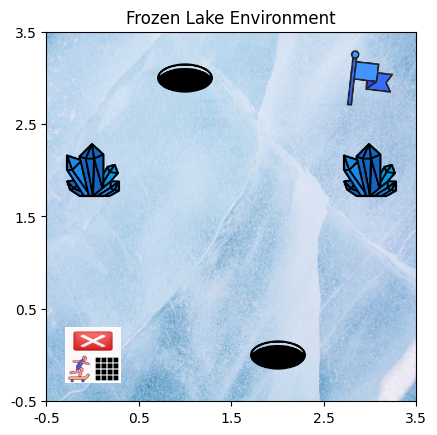

Chosen Action: 3
Step 2 - Action: 3, Reward: -0.1
Current State:
[[0.2 0.  0.5 0. ]
 [0.  0.  0.  0.4]
 [0.4 0.  0.  0. ]
 [0.  0.  0.5 0.8]]


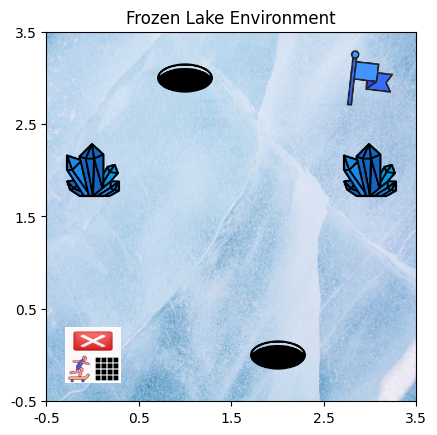

Chosen Action: 1
Step 3 - Action: 1, Reward: -0.1
Current State:
[[0.2 0.  0.5 0. ]
 [0.  0.  0.  0.4]
 [0.4 0.  0.  0. ]
 [0.  0.  0.5 0.8]]


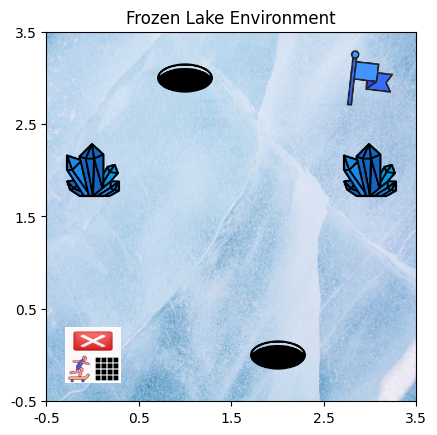

Chosen Action: 0
Step 4 - Action: 0, Reward: 1
Current State:
[[0.  0.  0.5 0. ]
 [0.2 0.  0.  0.4]
 [0.4 0.  0.  0. ]
 [0.  0.  0.5 0.8]]


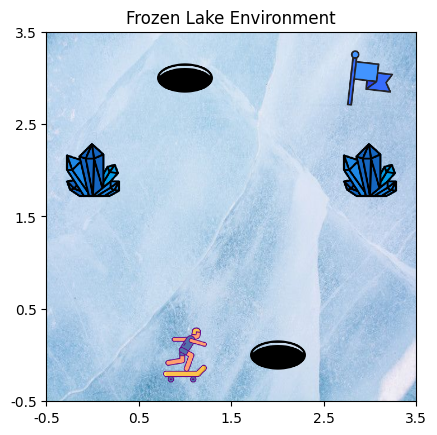

Chosen Action: 3
Step 5 - Action: 3, Reward: -0.1
Current State:
[[0.  0.  0.5 0. ]
 [0.2 0.  0.  0.4]
 [0.4 0.  0.  0. ]
 [0.  0.  0.5 0.8]]


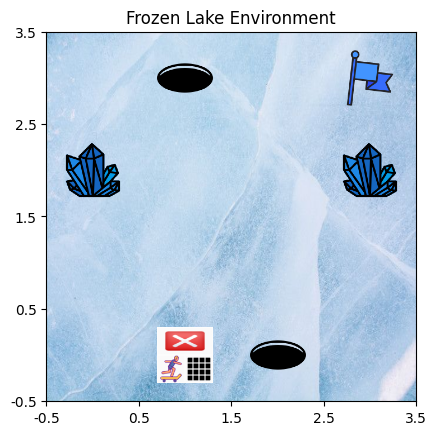

Chosen Action: 2
Step 6 - Action: 2, Reward: 1
Current State:
[[0.  0.  0.5 0. ]
 [0.  0.2 0.  0.4]
 [0.4 0.  0.  0. ]
 [0.  0.  0.5 0.8]]


Chosen Action: 2
Step 7 - Action: 2, Reward: 1
Current State:
[[0.  0.  0.5 0. ]
 [0.  0.  0.2 0.4]
 [0.4 0.  0.  0. ]
 [0.  0.  0.5 0.8]]


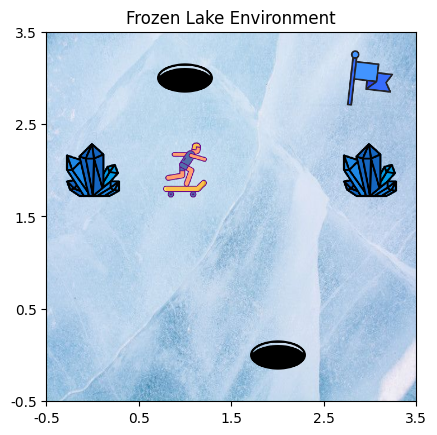

Chosen Action: 3
Step 8 - Action: 3, Reward: -1
Current State:
[[0.  0.  0.5 0. ]
 [0.  0.2 0.  0.4]
 [0.4 0.  0.  0. ]
 [0.  0.  0.5 0.8]]


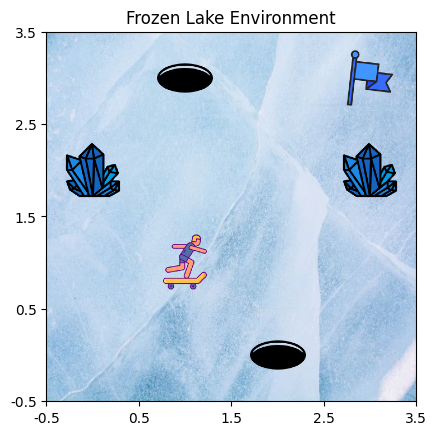

Chosen Action: 2
Step 9 - Action: 2, Reward: 1
Current State:
[[0.  0.  0.5 0. ]
 [0.  0.  0.2 0.4]
 [0.4 0.  0.  0. ]
 [0.  0.  0.5 0.8]]


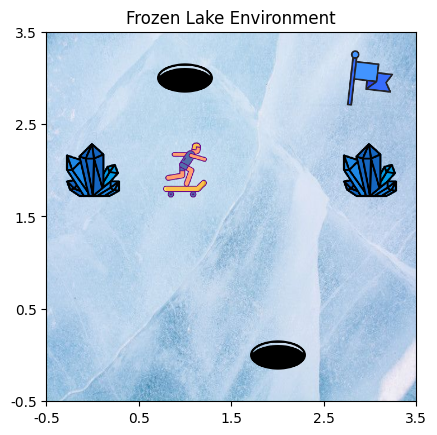

Chosen Action: 1
Step 10 - Action: 1, Reward: 5
Current State:
[[0.  0.  0.5 0. ]
 [0.  0.  0.  0.4]
 [0.4 0.  0.  0. ]
 [0.  0.  0.5 0.8]]


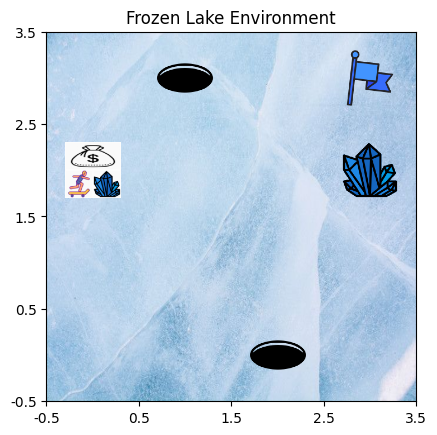

Resetting environment due to termination or truncation.


In [10]:
for _ in range(10):
    actn=env_dqn_skater.action_space.sample()
    obs,rd,terminated,truncated,info=env_dqn_skater.step(actn)
    print(f"Chosen Action: {actn}")
    print(f"Step {_+1}-Action: {actn},Reward: {rd}")
    print("Current State:")
    print(env_dqn_skater.stt)
    env_dqn_skater.render()
    if terminated or truncated:
        print("Resetting environment due to termination or truncation.")
        obs=env_dqn_skater.reset()

In [13]:
obs=env_dqn_skater.reset()
info=obs[1] if isinstance(obs,tuple)and len(obs)> 1 else None

stt=obs[0] if isinstance(obs,tuple) else obs

n_obs=len(stt)
n_act=env_dqn_skater.action_space.n

policyy_network=DQN(n_obs,
                    n_act).to(device)
targett_network=DQN(n_obs,
                    n_act).to(device)
targett_network.load_state_dict(policyy_network.state_dict())

optimizer=optim.AdamW(policyy_network.parameters(),
                      lr=learning,
                      amsgrad=True)
mem=replay_mem(10000)
stp_done=0

In [14]:
epi_dur=[]

In [12]:
epis=800

total_rewards_dqn_skater=[]
epsilons_dqn_skater=[]

for i_episode in range(epis):
    obs=env_dqn_skater.reset()
    info=obs[1] if isinstance(obs,tuple)and len(obs)> 1 else None

    stt=obs[0] if isinstance(obs,tuple)else obs
    stt=torch.tensor(stt,
                     dtype=torch.float32,
                     device=device).unsqueeze(0)

    total_reward=0
    epsilons_dqn_skater.append(eps_ends+(eps_begins-eps_ends)* math.exp(-1.*stp_done/decayy))
    
    for t in count():
        actn=select_action(stt,
                           env_dqn_skater)
        obsn,rd,terminated,truncated,_=env_dqn_skater.step(actn.item())
        rd=torch.tensor([rd],
                        device=device)
        done=terminated or truncated
        total_reward += rd.item()

        if terminated:
            nxt_stt=None
        else:
            nxt_stt=torch.tensor(obsn,
                                 dtype=torch.float32,
                                 device=device).unsqueeze(0)

        mem.push(stt,
                 actn,
                 nxt_stt,
                 rd)
        
        stt=nxt_stt
        opt_m()
        
        targett_network_stt_dict=targett_network.state_dict()
        policyy_network_stt_dict=policyy_network.state_dict()
        
        for key in policyy_network_stt_dict:
            targett_network_stt_dict[key]=policyy_network_stt_dict[key]*tau+targett_network_stt_dict[key]*(1-tau)
        targett_network.load_state_dict(targett_network_stt_dict)

        if done:
            total_rewards_dqn_skater.append(total_reward)
            epi_dur.append(t+1)
            duration()
            break

print('Complete')
duration(show_result=True)
plt.ioff()
plt.show()


Complete


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

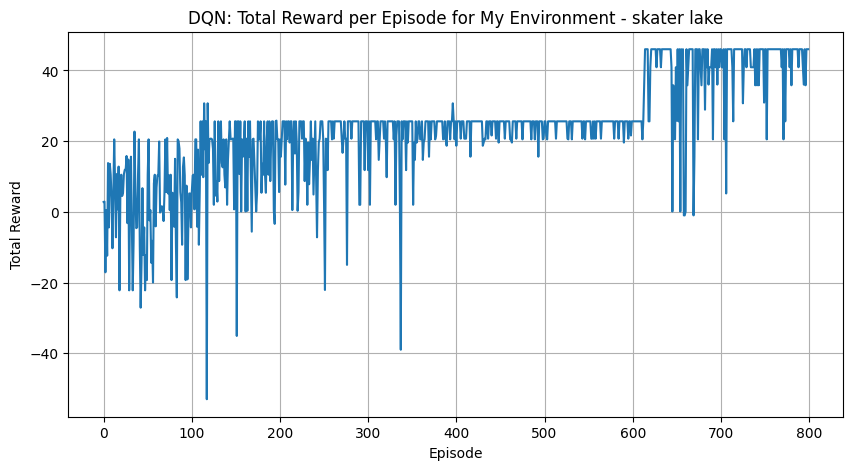

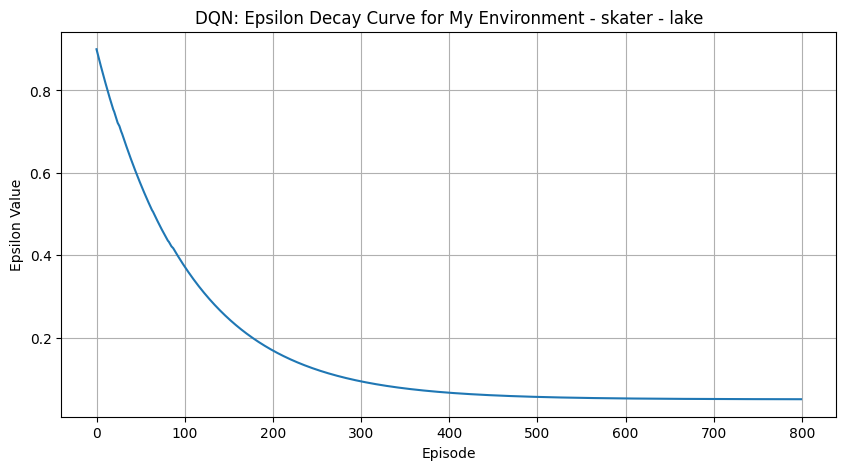

In [13]:
plt.figure(figsize=(10,5))
plt.plot(total_rewards_dqn_skater)
plt.title('DQN: Total Reward per Episode for My Environment-skater lake')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(epsilons_dqn_skater)
plt.title('DQN: Epsilon Decay Curve for My Environment-skater-lake')
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')
plt.grid(True)
plt.show()

In [14]:
torch.save(policyy_network.state_dict(),'grid-wrold_dqn_model_weights.pth')

In [15]:
eval_epi=10
evaluation_rewards_dqn_skater=[]

for i_episode in range(eval_epi):
    obs=env_dqn_skater.reset()
    info=obs[1] if isinstance(obs,tuple)and len(obs)> 1 else None

    stt=obs[0] if isinstance(obs,tuple)else obs
    stt=torch.tensor(stt,
                     dtype=torch.float32,
                     device=device).unsqueeze(0)
    total_reward=0

    for t in count():
        with torch.no_grad():
            actn=policyy_network(stt).max(1)[1].view(1,1)
        obsn,rd,terminated,truncated,_=env_dqn_skater.step(actn.item())
        total_reward += rd
        if terminated or truncated:
            break
        stt=torch.tensor(obsn,
                         dtype=torch.float32,
                         device=device).unsqueeze(0)
    evaluation_rewards_dqn_skater.append(total_reward)

plt.figure(figsize=(10,5))
plt.plot(evaluation_rewards_dqn_skater,
         marker='o')
plt.title('DQN: Total Reward per Episode for Evaluation (Greedy Policy)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()

# 2.2 Applying DQN to solve various RL problems

## CartPole

In [16]:
env_dqn_cartpole=gym.make('CartPole-v1',new_step_api=True).unwrapped

In [ ]:
obs=env_dqn_cartpole.reset()
info=obs[1] if isinstance(obs,tuple)and len(obs)> 1 else None

stt=obs[0] if isinstance(obs,tuple)else obs

n_obs=len(stt)
n_act=env_dqn_cartpole.action_space.n

policyy_network=DQN(n_obs,
                    n_act).to(device)
targett_network=DQN(n_obs,
                    n_act).to(device)
targett_network.load_state_dict(policyy_network.state_dict())

optimizer=optim.AdamW(policyy_network.parameters(),
                      lr=learning,
                      amsgrad=True)
mem=replay_mem(10000)
stp_done=0

Complete


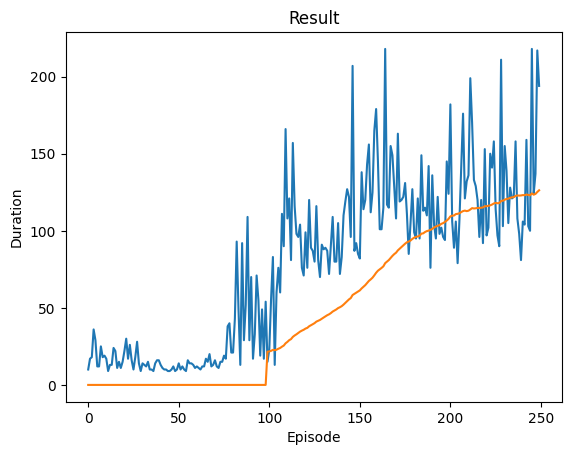

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
epis=250
epi_dur=[]
total_rewards_dqn_cartpole=[]
epsilons_dqn_cartpole=[]

for i_episode in range(epis):
    obs=env_dqn_cartpole.reset()
    info=obs[1] if isinstance(obs,tuple)and len(obs)> 1 else None

    stt=obs[0] if isinstance(obs,tuple)else obs
    stt=torch.tensor(stt,
                     dtype=torch.float32,
                     device=device).unsqueeze(0)

    total_reward=0
    epsilons_dqn_cartpole.append(eps_ends+(eps_begins-eps_ends)* math.exp(-1.*stp_done/decayy))
    for t in count():
        actn=select_action(stt,
                           env_dqn_cartpole)
        obsn,rd,terminated,truncated,_=env_dqn_cartpole.step(actn.item())
        rd=torch.tensor([rd],
                        device=device)
        done=terminated or truncated
        total_reward += rd.item()

        if terminated:
            nxt_stt=None
        else:
            nxt_stt=torch.tensor(obsn,
                                 dtype=torch.float32,
                                 device=device).unsqueeze(0)

        mem.push(stt,actn,nxt_stt,rd)
        stt=nxt_stt
        opt_m()

        targett_network_stt_dict=targett_network.state_dict()
        policyy_network_stt_dict=policyy_network.state_dict()
        for key in policyy_network_stt_dict:
            targett_network_stt_dict[key]=policyy_network_stt_dict[key]*tau+targett_network_stt_dict[key]*(1-tau)
        targett_network.load_state_dict(targett_network_stt_dict)

        if done:
            total_rewards_dqn_cartpole.append(total_reward)
            epi_dur.append(t+1)
            duration()
            break

print('Complete')
duration(show_result=True)
plt.ioff()
plt.show()

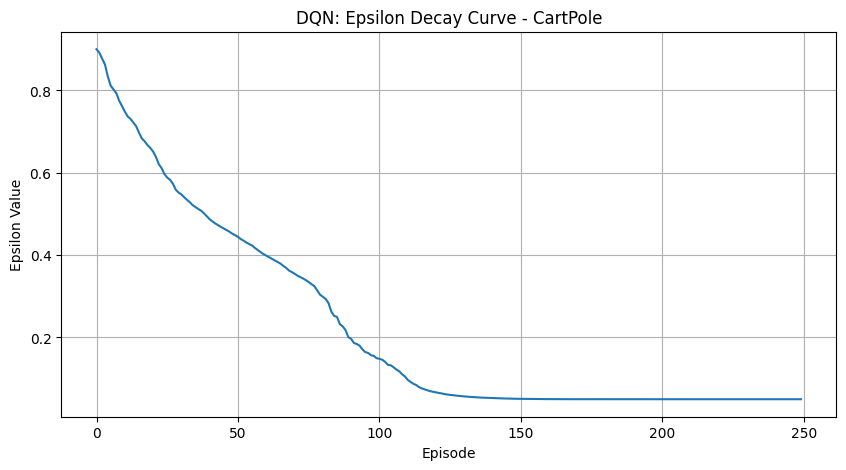

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(total_rewards_dqn_cartpole)
plt.title('DQN: Total Reward per Episode-CartPole')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(epsilons_dqn_cartpole)
plt.title('DQN: Epsilon Decay Curve-CartPole')
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')
plt.grid(True)
plt.show()

In [ ]:
torch.save(policyy_network.state_dict(),'cart-pole_dqn_model_weights.pth')

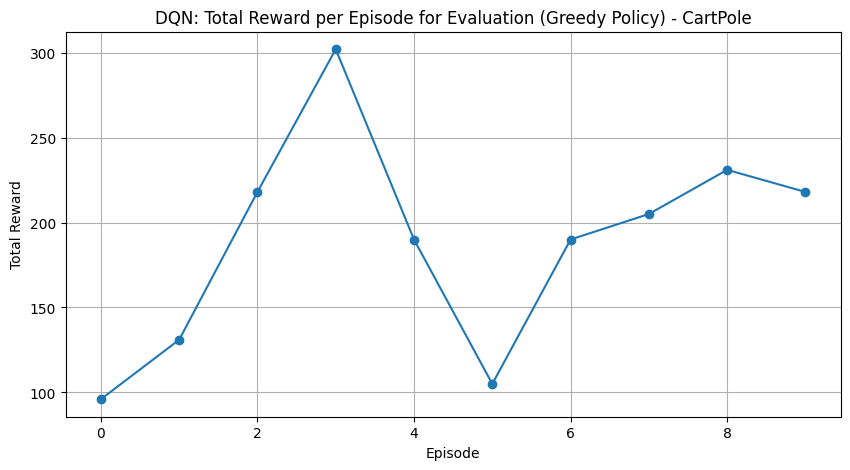

In [ ]:
eval_epi=10
evaluation_rewards_dqn_cartpole=[]

for i_episode in range(eval_epi):
    obs=env_dqn_cartpole.reset()

    stt=obs if not isinstance(obs,tuple)else obs[0]
    stt=torch.tensor([stt],
                     dtype=torch.float32,
                     device=device)

    total_reward=0

    for t in count():
        with torch.no_grad():
            actn=policyy_network(stt).max(1)[1].view(1,1)
        obsn,rd,terminated,truncated,_=env_dqn_cartpole.step(actn.item())
        total_reward += rd
        if terminated or truncated:
            break
        stt=torch.tensor([obsn],
                         dtype=torch.float32,
                         device=device)

    evaluation_rewards_dqn_cartpole.append(total_reward)

plt.figure(figsize=(10,5))
plt.plot(evaluation_rewards_dqn_cartpole,marker='o')
plt.title('DQN: Total Reward per Episode for Evaluation (Greedy Policy)- CartPole')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()

## Mountain Car

In [ ]:
env_dqn_mountaincar=gym.make('MountainCar-v0',new_step_api=True).unwrapped

In [ ]:
obs=env_dqn_mountaincar.reset()
info=obs[1] if isinstance(obs,tuple)and len(obs)> 1 else None

stt=obs[0] if isinstance(obs,tuple)else obs
n_obs=len(stt)
n_act=env_dqn_mountaincar.action_space.n

policyy_network=DQN(n_obs,
                    n_act).to(device)
targett_network=DQN(n_obs,
                    n_act).to(device)
targett_network.load_state_dict(policyy_network.state_dict())

optimizer=optim.AdamW(policyy_network.parameters(),
                      lr=learning,
                      amsgrad=True)
mem=replay_mem(10000)
stp_done=0

In [ ]:
epi_dur=[]

Complete


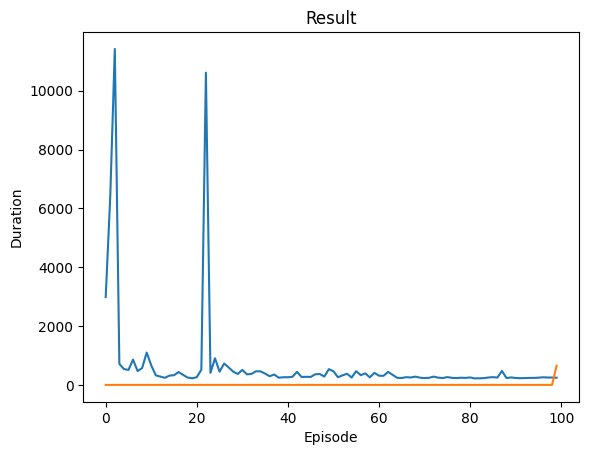

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
epis=100

total_rewards_dqn_mountaincar=[]
epsilons_dqn_mountaincar=[]

for i_episode in range(epis):
    obs=env_dqn_mountaincar.reset()
    info=obs[1] if isinstance(obs,tuple)and len(obs)> 1 else None

    stt=obs[0] if isinstance(obs,tuple)else obs
    stt=torch.tensor(stt,
                     dtype=torch.float32,
                     device=device).unsqueeze(0)

    total_reward=0
    epsilons_dqn_mountaincar.append(eps_ends+(eps_begins-eps_ends)* math.exp(-1.*stp_done/decayy))

    for t in count():
        actn=select_action(stt,
                           env_dqn_mountaincar)
        obsn,rd,terminated,truncated,_=env_dqn_mountaincar.step(actn.item())
        rd=torch.tensor([rd],
                        device=device)
        done=terminated or truncated
        total_reward += rd.item()

        if terminated:
            nxt_stt=None
        else:
            nxt_stt=torch.tensor(obsn,
                                 dtype=torch.float32,
                                 device=device).unsqueeze(0)

        mem.push(stt,actn,nxt_stt,rd)
        stt=nxt_stt
        opt_m()

        targett_network_stt_dict=targett_network.state_dict()
        policyy_network_stt_dict=policyy_network.state_dict()
        for key in policyy_network_stt_dict:
            targett_network_stt_dict[key]=policyy_network_stt_dict[key]*tau+targett_network_stt_dict[key]*(1-tau)
        targett_network.load_state_dict(targett_network_stt_dict)

        if done:
            total_rewards_dqn_mountaincar.append(total_reward)
            epi_dur.append(t+1)
            duration()
            break

print('Complete')
duration(show_result=True)
plt.ioff()
plt.show()

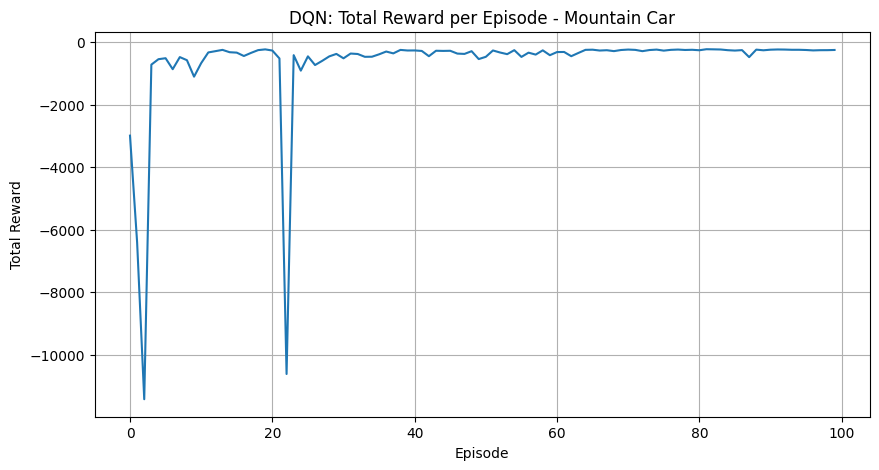

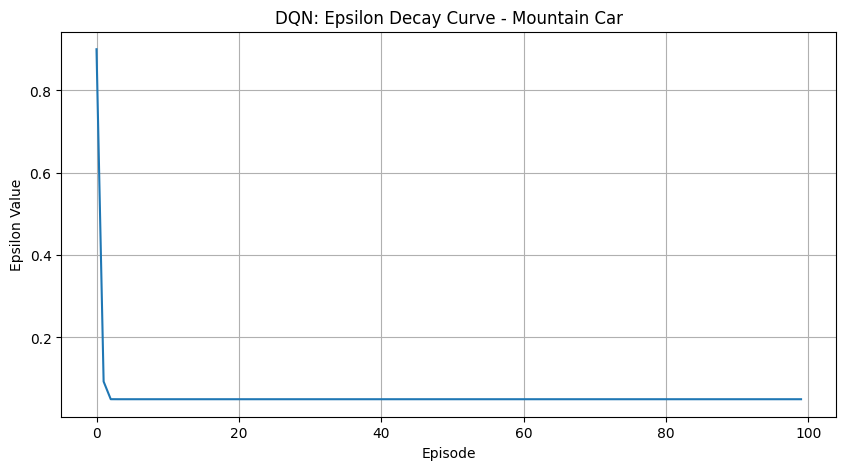

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(total_rewards_dqn_mountaincar)
plt.title('DQN: Total Reward per Episode-Mountain Car')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(epsilons_dqn_mountaincar)
plt.title('DQN: Epsilon Decay Curve-Mountain Car')
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')
plt.grid(True)
plt.show()

In [ ]:
torch.save(policyy_network.state_dict(),'mountain-car_dqn_model_weights.pth')

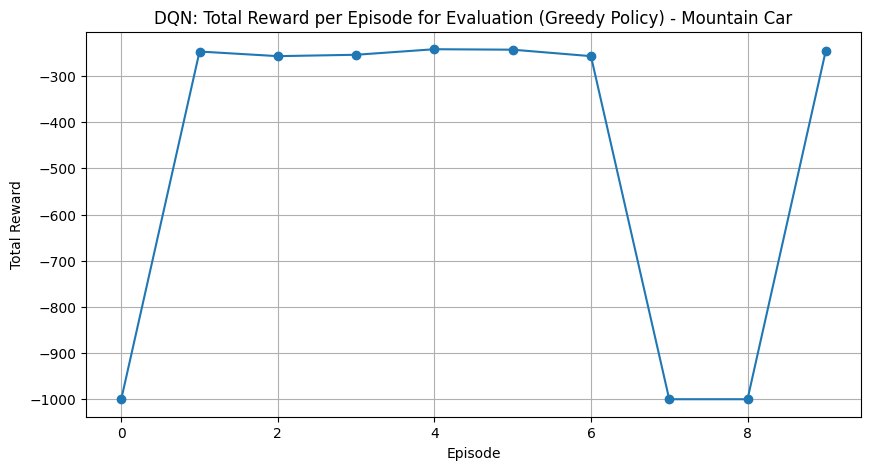

In [ ]:
eval_epi=10
evaluation_rewards_dqn_mountaincar=[]
max_steps_per_episode=1000

for i_episode in range(eval_epi):
    obs=env_dqn_mountaincar.reset()
    stt=obs[0] if isinstance(obs,tuple)else obs
    stt=torch.tensor(stt,
                     dtype=torch.float32,
                     device=device).unsqueeze(0)
    
    total_reward=0

    for t in range(max_steps_per_episode):
        with torch.no_grad():
            actn=policyy_network(stt).max(1)[1].view(1,1)
        obsn,rd,terminated,truncated,_=env_dqn_mountaincar.step(actn.item())
        total_reward += rd
        stt=torch.tensor(obsn,
                         dtype=torch.float32,
                         device=device).unsqueeze(0)
        if terminated or truncated:
            break
    evaluation_rewards_dqn_mountaincar.append(total_reward)

plt.figure(figsize=(10,5))
plt.plot(evaluation_rewards_dqn_mountaincar,
         marker='o')
plt.title('DQN: Total Reward per Episode for Evaluation (Greedy Policy)- Mountain Car')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()


# Improving DQN & Solving Various Problems

# 3.1 Improving vanilla version of DQN

## DDQN

In [16]:
def opt_m():
    if len(mem)< batchsize:
        return
    trans=mem.sample(batchsize)
    batch=transiton(*zip(*trans))

    not_mask=torch.tensor(tuple(map(lambda s: s is not None,
                                    batch.nxt_stt)),
                                    device=device,
                                    dtype=torch.bool)
    not_nxt_stt=torch.cat([s for s in batch.nxt_stt if s is not None])

    stt_batch=torch.cat(batch.stt)
    act_batch=torch.cat(batch.actn)
    r_batch=torch.cat(batch.rd)

    stt_act_val=policyy_network(stt_batch).gather(1,act_batch)
    policyy_network_bst_act=policyy_network(not_nxt_stt).max(1)[1].unsqueeze(1)
    nxt_stt_val=torch.zeros(batchsize,
                            device=device)

    with torch.no_grad():
        nxt_stt_val[not_mask]=targett_network(not_nxt_stt).gather(1,policyy_network_bst_act).squeeze()

    exp_stt_act_val=(nxt_stt_val*G)+ r_batch
    
    criterion=nn.SmoothL1Loss()
    loss=criterion(stt_act_val,
                   exp_stt_act_val.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policyy_network.parameters(),100)
    optimizer.step()


In [17]:
batchsize=128
G=0.99
eps_begins=0.9
eps_ends=0.05
decayy=1000
tau=0.005
learning=1e-4


## My Environment-Frozen Lake Grid World

In [18]:
env_ddqn_skater=FrozenLakeEnv()

In [19]:
obs=env_ddqn_skater.reset()
info=obs[1] if isinstance(obs,tuple)and len(obs)> 1 else None

stt=obs[0] if isinstance(obs,tuple)else obs

n_obs=len(stt)
n_act=env_ddqn_skater.action_space.n

policyy_network=DQN(n_obs,
                    n_act).to(device)
targett_network=DQN(n_obs,
                    n_act).to(device)
targett_network.load_state_dict(policyy_network.state_dict())

optimizer=optim.AdamW(policyy_network.parameters(),
                      lr=learning,
                      amsgrad=True)
mem=replay_mem(10000)
stp_done=0

In [20]:
epi_dur=[]

Complete


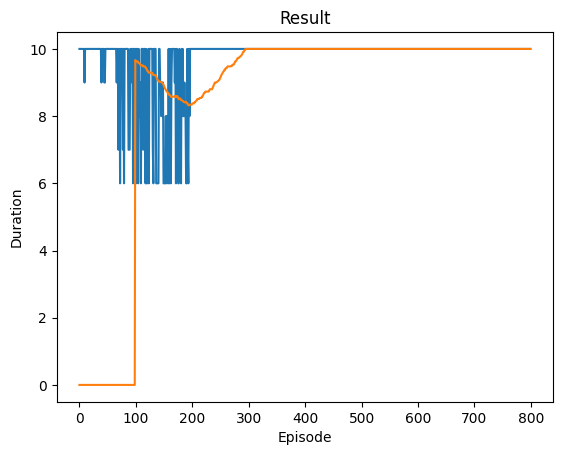

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [21]:
epis=800

total_rewards_ddqn_skater=[]
epsilons_ddqn_skater=[]

for i_episode in range(epis):
    obs=env_ddqn_skater.reset()
    info=obs[1] if isinstance(obs,tuple)and len(obs)> 1 else None

    stt=obs[0] if isinstance(obs,tuple)else obs
    stt=torch.tensor(stt,
                     dtype=torch.float32,
                     device=device).unsqueeze(0)
    total_reward=0
    epsilons_ddqn_skater.append(eps_ends+(eps_begins-eps_ends)* math.exp(-1.*stp_done/decayy))

    for t in count():
        actn=select_action(stt,
                           env_ddqn_skater)
        obsn,rd,terminated,truncated,_=env_ddqn_skater.step(actn.item())
        rd=torch.tensor([rd],
                        device=device)
        done=terminated or truncated
        total_reward += rd.item()
        if terminated:
            nxt_stt=None
        else:
            nxt_stt=torch.tensor(obsn,
                                 dtype=torch.float32,
                                 device=device).unsqueeze(0)

        mem.push(stt,
                 actn,
                 nxt_stt,
                 rd)
        stt=nxt_stt
        opt_m()

        targett_network_stt_dict=targett_network.state_dict()
        policyy_network_stt_dict=policyy_network.state_dict()

        for key in policyy_network_stt_dict:
            targett_network_stt_dict[key]=policyy_network_stt_dict[key]*tau+targett_network_stt_dict[key]*(1-tau)
        targett_network.load_state_dict(targett_network_stt_dict)

        if done:
            total_rewards_ddqn_skater.append(total_reward)
            epi_dur.append(t+1)
            duration()
            break

print('Complete')
duration(show_result=True)
plt.ioff()
plt.show()

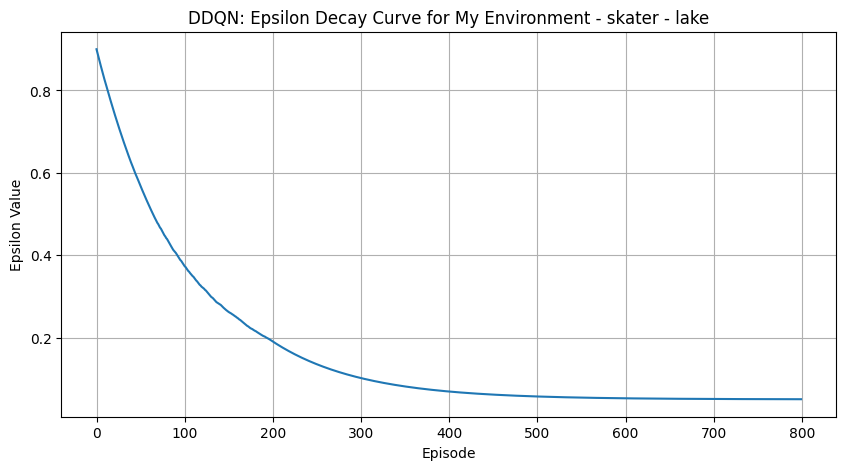

In [22]:
plt.figure(figsize=(10,5))
plt.plot(total_rewards_ddqn_skater)
plt.title('DDQN: Total Reward per Episode for My Environment-skater-lake')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(epsilons_ddqn_skater)
plt.title('DDQN: Epsilon Decay Curve for My Environment-skater-lake')
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')
plt.grid(True)
plt.show()

In [23]:
torch.save(policyy_network.state_dict(),'grid-wrold_ddqn_model_weights.pth')

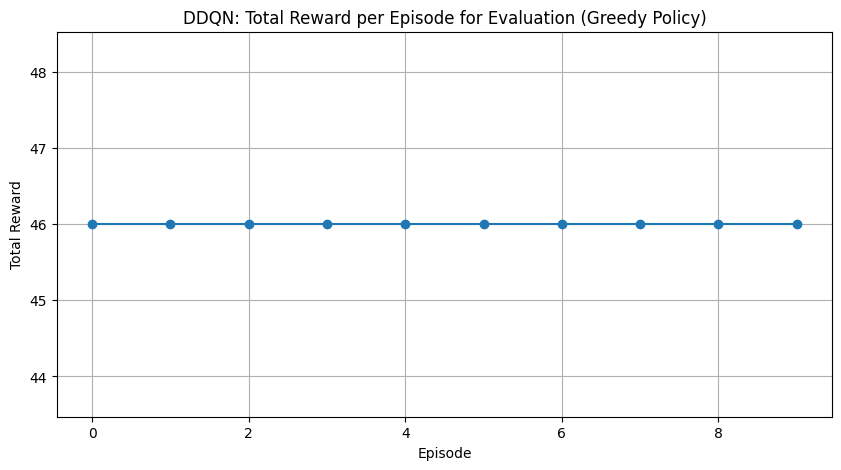

In [24]:
eval_epi=10
evaluation_rewards_ddqn_skater=[]

for i_episode in range(eval_epi):
    obs=env_ddqn_skater.reset()
    info=obs[1] if isinstance(obs,tuple)and len(obs)> 1 else None

    stt=obs[0] if isinstance(obs,tuple)else obs
    stt=torch.tensor(stt,
                     dtype=torch.float32,
                     device=device).unsqueeze(0)
    total_reward=0

    for t in count():
        with torch.no_grad():
            actn=policyy_network(stt).max(1)[1].view(1,1)
        obsn,rd,terminated,truncated,_=env_ddqn_skater.step(actn.item())
        total_reward += rd
        if terminated or truncated:
            break
        stt=torch.tensor(obsn,
                         dtype=torch.float32,
                         device=device).unsqueeze(0)
    evaluation_rewards_ddqn_skater.append(total_reward)

plt.figure(figsize=(10,5))
plt.plot(evaluation_rewards_ddqn_skater,marker='o')
plt.title('DDQN: Total Reward per Episode for Evaluation (Greedy Policy)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()

# 3.2 Applying improved version of DQN algorithm to solve TWO environments

## CartPole

In [ ]:
env_ddqn_cartpole=gym.make('CartPole-v1',new_step_api=True).unwrapped

In [ ]:
obs=env_ddqn_cartpole.reset()
info=obs[1] if isinstance(obs,tuple)and len(obs)> 1 else None
stt=obs[0] if isinstance(obs,tuple)else obs

n_obs=len(stt)
n_act=env_ddqn_cartpole.action_space.n

policyy_network=DQN(n_obs,
                    n_act).to(device)
targett_network=DQN(n_obs,
                    n_act).to(device)
targett_network.load_state_dict(policyy_network.state_dict())

optimizer=optim.AdamW(policyy_network.parameters(),
                      lr=learning,
                      amsgrad=True)
mem=replay_mem(10000)
stp_done=0

In [ ]:
epis=250
epi_dur=[]
total_rewards_ddqn_cartpole=[]
epsilons_ddqn_cartpole=[]

for i_episode in range(epis):
    obs=env_ddqn_cartpole.reset()
    info=obs[1] if isinstance(obs,tuple)and len(obs)> 1 else None

    stt=obs[0] if isinstance(obs,tuple)else obs
    stt=torch.tensor(stt,
                     dtype=torch.float32,
                     device=device).unsqueeze(0)

    total_reward=0
    epsilons_ddqn_cartpole.append(eps_ends+(eps_begins-eps_ends)* math.exp(-1.*stp_done/decayy))
    for t in count():
        actn=select_action(stt,
                           env_ddqn_cartpole)
        obsn,rd,terminated,truncated,_=env_ddqn_cartpole.step(actn.item())
        rd=torch.tensor([rd],
                        device=device)
        done=terminated or truncated
        total_reward += rd.item()
        if terminated:
            nxt_stt=None
        else:
            nxt_stt=torch.tensor(obsn,
                                 dtype=torch.float32,
                                 device=device).unsqueeze(0)

        mem.push(stt,
                 actn,
                 nxt_stt,
                 rd)
        
        stt=nxt_stt
        opt_m()
        targett_network_stt_dict=targett_network.state_dict()
        policyy_network_stt_dict=policyy_network.state_dict()

        for key in policyy_network_stt_dict:
            targett_network_stt_dict[key]=policyy_network_stt_dict[key]*tau+targett_network_stt_dict[key]*(1-tau)
        targett_network.load_state_dict(targett_network_stt_dict)

        if done:
            total_rewards_ddqn_cartpole.append(total_reward)
            epi_dur.append(t+1)
            duration()
            break

print('Complete')
duration(show_result=True)
plt.ioff()
plt.show()

Complete


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

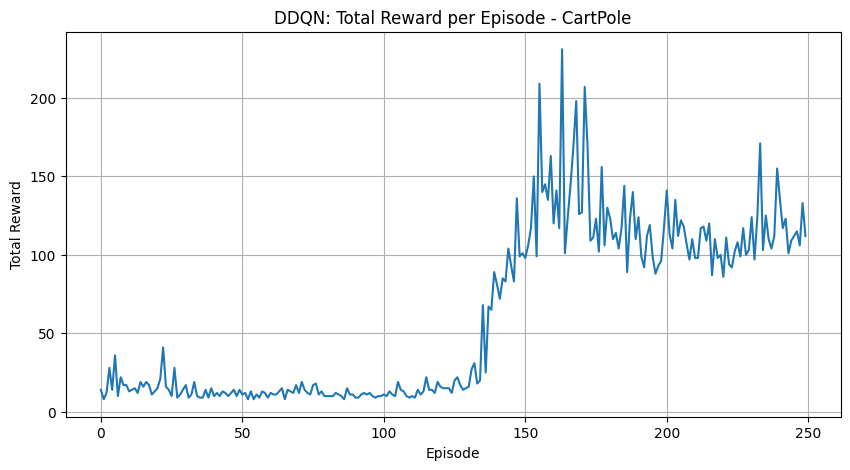

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(total_rewards_ddqn_cartpole)
plt.title('DDQN: Total Reward per Episode-CartPole')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(epsilons_ddqn_cartpole)
plt.title('DDQN: Epsilon Decay Curve-CartPole')
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')
plt.grid(True)
plt.show()

In [ ]:
torch.save(policyy_network.state_dict(),'cart-pole_ddqn_model_weights.pth')

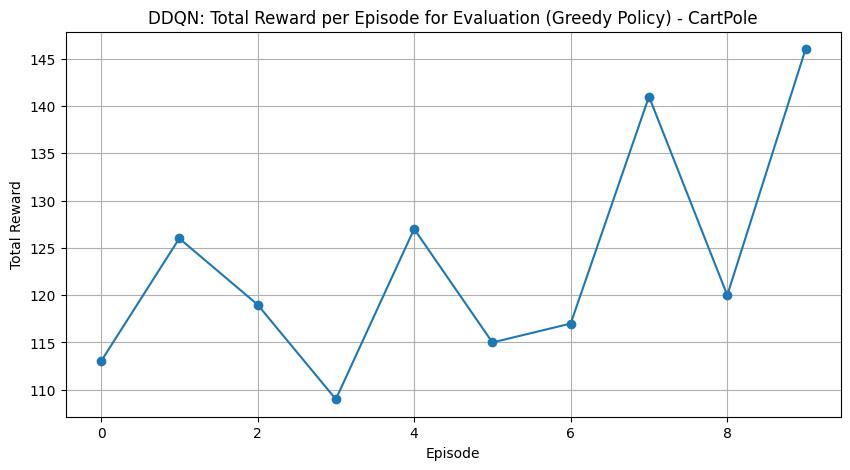

In [ ]:
eval_epi=10
evaluation_rewards_ddqn_cartpole=[]

for i_episode in range(eval_epi):
    obs=env_ddqn_cartpole.reset()
    info=obs[1] if isinstance(obs,tuple)and len(obs)> 1 else None

    stt=obs[0] if isinstance(obs,tuple)else obs
    stt=torch.tensor(stt,
                     dtype=torch.float32,
                     device=device).unsqueeze(0)

    total_reward=0
    for t in count():
        with torch.no_grad():
            actn=policyy_network(stt).max(1)[1].view(1,1)
        obsn,rd,terminated,truncated,_=env_ddqn_cartpole.step(actn.item())
        total_reward += rd
        if terminated or truncated:
            break
        stt=torch.tensor(obsn,
                         dtype=torch.float32,
                         device=device).unsqueeze(0)
    evaluation_rewards_ddqn_cartpole.append(total_reward)

plt.figure(figsize=(10,5))
plt.plot(evaluation_rewards_ddqn_cartpole,marker='o')
plt.title('DDQN: Total Reward per Episode for Evaluation (Greedy Policy)- CartPole')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()


## Mountain Car

In [ ]:
env_ddqn_mountaincar=gym.make('MountainCar-v0',new_step_api=True).unwrapped

In [ ]:
obs=env_ddqn_mountaincar.reset()
info=obs[1] if isinstance(obs,tuple)and len(obs)> 1 else None
stt=obs[0] if isinstance(obs,tuple)else obs

n_obs=len(stt)
n_act=env_ddqn_mountaincar.action_space.n

policyy_network=DQN(n_obs,
                    n_act).to(device)
targett_network=DQN(n_obs,
                    n_act).to(device)
targett_network.load_state_dict(policyy_network.state_dict())

optimizer=optim.AdamW(policyy_network.parameters(),
                      lr=learning,
                      amsgrad=True)
mem=replay_mem(10000)
stp_done=0

In [ ]:
epi_dur=[]

In [ ]:
epis=100

total_rewards_ddqn_mountaincar=[]
epsilons_ddqn_mountaincar=[]

for i_episode in range(epis):
    obs=env_ddqn_mountaincar.reset()
    info=obs[1] if isinstance(obs,tuple)and len(obs)> 1 else None

    stt=obs[0] if isinstance(obs,tuple)else obs
    stt=torch.tensor(stt,
                     dtype=torch.float32,
                     device=device).unsqueeze(0)

    total_reward=0
    epsilons_ddqn_mountaincar.append(eps_ends+(eps_begins-eps_ends)* math.exp(-1.*stp_done/decayy))
    for t in count():
        actn=select_action(stt,
                           env_ddqn_mountaincar)
        obsn,rd,terminated,truncated,_=env_ddqn_mountaincar.step(actn.item())
        rd=torch.tensor([rd],
                        device=device)
        done=terminated or truncated
        total_reward += rd.item()
        if terminated:
            nxt_stt=None
        else:
            nxt_stt=torch.tensor(obsn,
                                 dtype=torch.float32,
                                 device=device).unsqueeze(0)

        mem.push(stt,
                 actn,
                 nxt_stt,
                 rd)
        stt=nxt_stt
        opt_m()
     
        targett_network_stt_dict=targett_network.state_dict()
        policyy_network_stt_dict=policyy_network.state_dict()
        for key in policyy_network_stt_dict:
            targett_network_stt_dict[key]=policyy_network_stt_dict[key]*tau+targett_network_stt_dict[key]*(1-tau)
        targett_network.load_state_dict(targett_network_stt_dict)

        if done:
            total_rewards_ddqn_mountaincar.append(total_reward)
            epi_dur.append(t+1)
            duration()
            break

print('Complete')
duration(show_result=True)
plt.ioff()
plt.show()

Complete


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(total_rewards_ddqn_mountaincar)
plt.title('DDQN: Total Reward per Episode-Mountain Car')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(epsilons_ddqn_mountaincar)
plt.title('DDQN: Epsilon Decay Curve-Mountain Car')
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')
plt.grid(True)
plt.show()

In [ ]:
torch.save(policyy_network.state_dict(),'mountain-car_ddqn_model_weights.pth')

In [ ]:
eval_epi=10
evaluation_rewards_ddqn_mountaincar=[]
maxi_ts=1000

for i_episode in range(eval_epi):
    obs=env_ddqn_mountaincar.reset()
    stt=obs[0] if isinstance(obs,tuple)else obs
    stt=torch.tensor(stt,
                     dtype=torch.float32,
                     device=device).unsqueeze(0)

    total_reward=0
    for t in range(maxi_ts):
        with torch.no_grad():
            actn=policyy_network(stt).max(1)[1].view(1,1)
        obsn,rd,terminated,truncated,_=env_ddqn_mountaincar.step(actn.item())
        total_reward += rd
        stt=torch.tensor(obsn,
                         dtype=torch.float32,
                         device=device).unsqueeze(0)
        if terminated or truncated:
            break
    evaluation_rewards_ddqn_mountaincar.append(total_reward)

plt.figure(figsize=(10,5))
plt.plot(evaluation_rewards_ddqn_mountaincar,marker='o')
plt.title('DDQN: Total Reward per Episode for Evaluation (Greedy Policy)- Mountain Car')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()


In [25]:
plt.figure(figsize=(12,6))
plt.plot(total_rewards_dqn_skater,label='DQN Rewards skater')
plt.plot(total_rewards_ddqn_skater,label='DDQN Rewards skater')
plt.title('Reward Comparison between DQN and DDQN-skater lake')
plt.xlabel('Episodes')
plt.ylabel('Total Rewards')
plt.legend()
plt.grid(True)
plt.show()

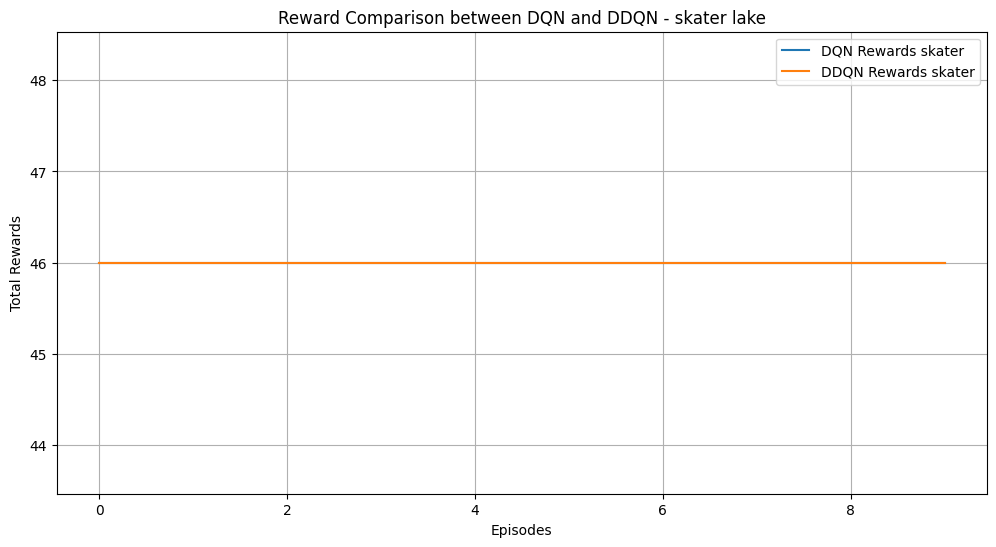

In [26]:
plt.figure(figsize=(12,6))
plt.plot(evaluation_rewards_dqn_skater,label='DQN Rewards skater')
plt.plot(evaluation_rewards_ddqn_skater,label='DDQN Rewards skater')
plt.title('Reward Comparison between DQN and DDQN-skater lake')
plt.xlabel('Episodes')
plt.ylabel('Total Rewards')
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


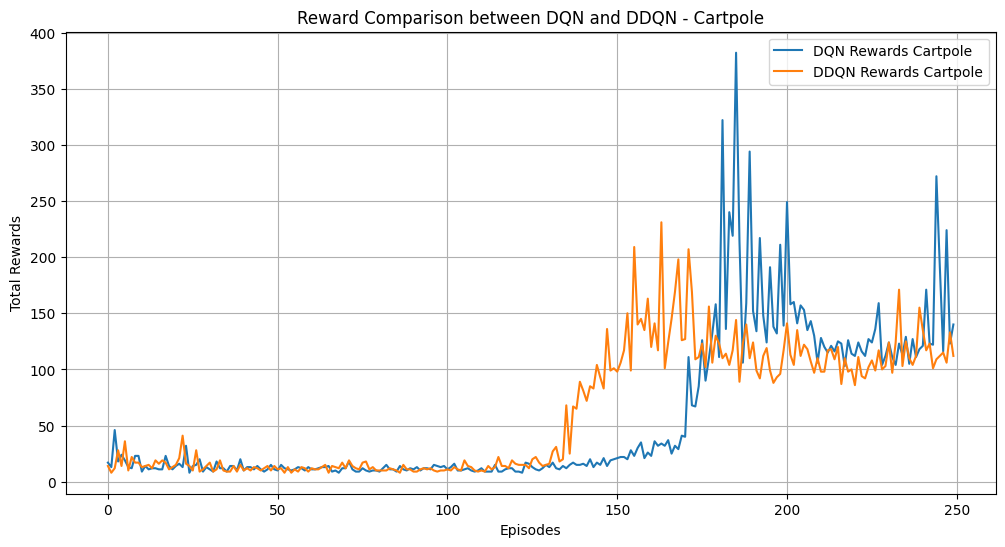

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(total_rewards_dqn_cartpole,label='DQN Rewards Cartpole')
plt.plot(total_rewards_ddqn_cartpole,label='DDQN Rewards Cartpole')
plt.title('Reward Comparison between DQN and DDQN-Cartpole')
plt.xlabel('Episodes')
plt.ylabel('Total Rewards')
plt.legend()
plt.grid(True)
plt.show()

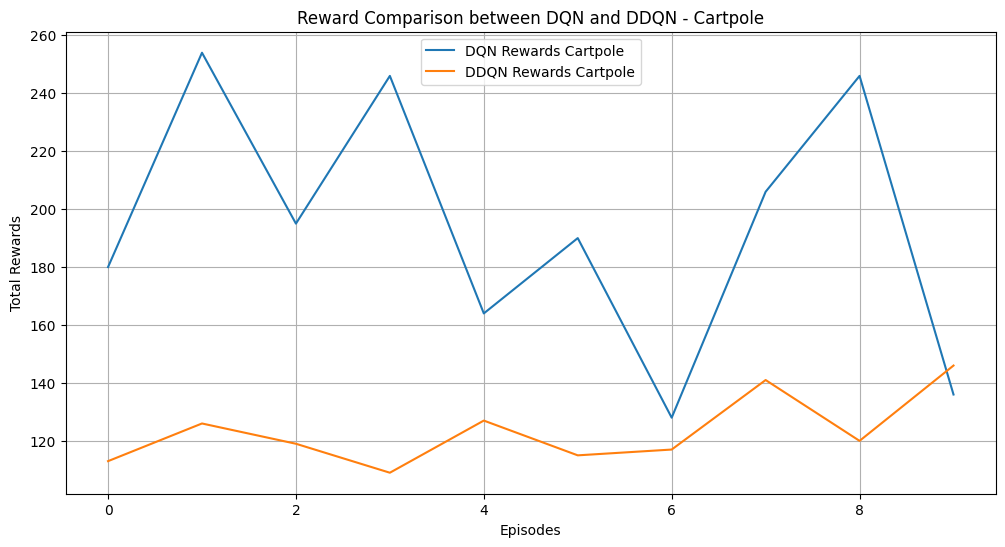

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(evaluation_rewards_dqn_cartpole,label='DQN Rewards Cartpole')
plt.plot(evaluation_rewards_ddqn_cartpole,label='DDQN Rewards Cartpole')
plt.title('Reward Comparison between DQN and DDQN-Cartpole')
plt.xlabel('Episodes')
plt.ylabel('Total Rewards')
plt.legend()
plt.grid(True)
plt.show()

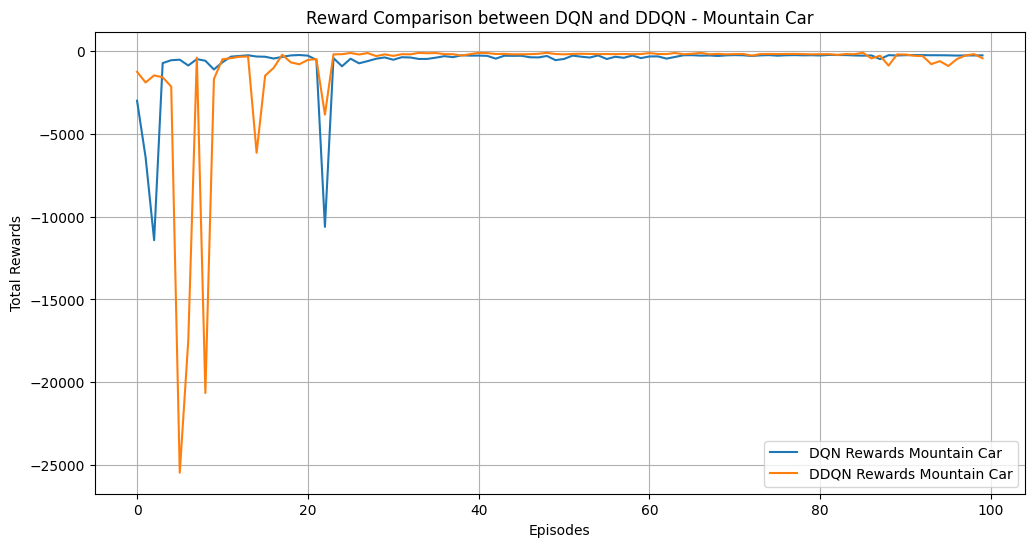

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(total_rewards_dqn_mountaincar,label='DQN Rewards Mountain Car')
plt.plot(total_rewards_ddqn_mountaincar,label='DDQN Rewards Mountain Car')
plt.title('Reward Comparison between DQN and DDQN-Mountain Car')
plt.xlabel('Episodes')
plt.ylabel('Total Rewards')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(evaluation_rewards_dqn_mountaincar,label='DQN Rewards Mountain Car')
plt.plot(evaluation_rewards_ddqn_mountaincar,label='DDQN Rewards Mountain Car')
plt.title('Reward Comparison between DQN and DDQN-Mountain Car')
plt.xlabel('Episodes')
plt.ylabel('Total Rewards')
plt.legend()
plt.grid(True)
plt.show()

## REFERENCE

- Our Environment is from Assignment 1 of Reinforcement Learning - Charvi Kusuma Submission.